# GAM

In [3]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from pykalman import KalmanFilter

from eval import MAE, custom_metric

from sklearn.metrics import mean_absolute_error as MAE
import matplotlib.pyplot as plt
from pygam import LinearGAM, s

import numpy as np
import pandas as pd

from preprocess import data

np.random.seed(0)


import numpy as np
import pandas as pd
from pygam import LinearGAM, s, te, f


In [5]:
x_tl = data["x_timed_lagged"].reset_index(drop=True).shift(1)
x_germany = data["x_germany"].reset_index(drop=True)
x_austria = data["x_austria"].reset_index(drop=True)
y_germany = data["y_germany"][1:].reset_index(drop=True)
y_austria = data["y_austria"][1:].reset_index(drop=True)

x_germany = pd.concat([x_germany, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])
x_austria = pd.concat([x_austria, x_tl[["GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]"]]], axis=1)[1:].reset_index(drop=True).drop(columns=["DATE_FROM"])

In [6]:
for k, x in enumerate(x_germany.columns.tolist()):
    print(k, x)

0 tavg
1 tmin
2 tmax
3 wdir
4 wspd
5 wpgt
6 pres
7 GERMANY_BLOCK_DEMAND_[MW]
8 TOTAL_DEMAND_[MW]
9 GERMANY_MARGINAL_CAPACITY_PRICE_[(EUR/MW)/h]


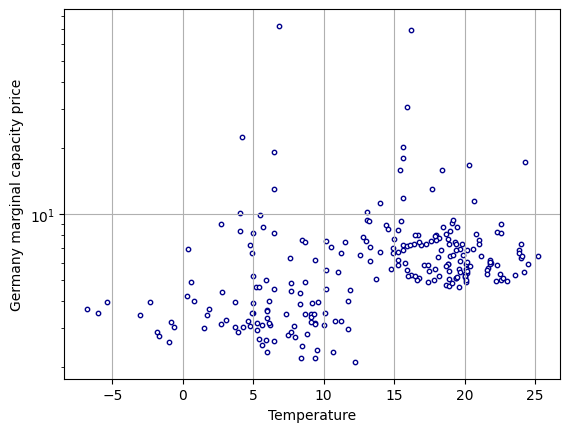

In [7]:
plt.scatter(x_germany["tavg"], y_germany, color='white', edgecolors='darkblue', s=10)
# plt.scatter(x, y, color='darkblue', edgecolor='black', s=100)
plt.title('')
plt.xlabel('Temperature')
plt.yscale('log')
plt.ylabel('Germany marginal capacity price')
plt.grid(True)
plt.savefig("tempearture_germany.png", dpi=300)
plt.show()



## GAM classiques

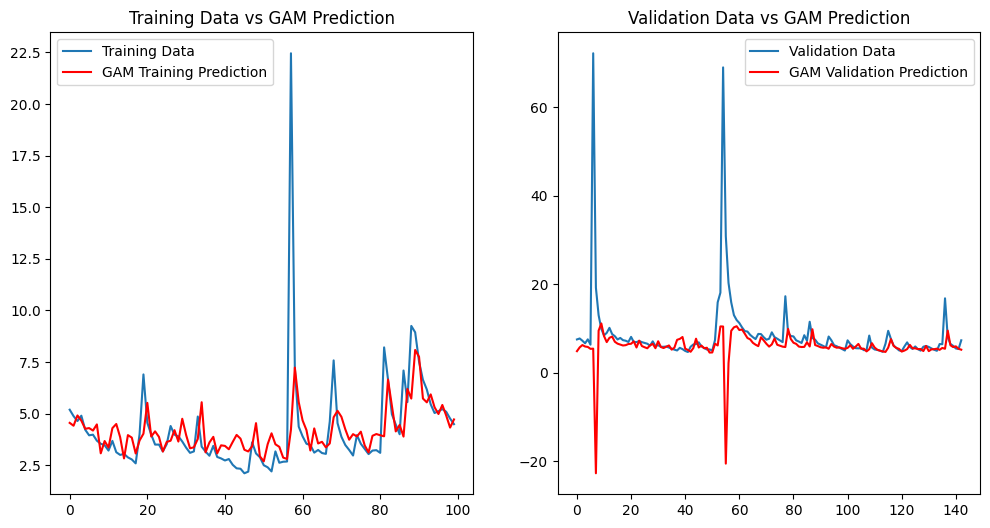

In [8]:
X, y = x_germany, y_germany

X_train = X[:100]
y_train = y[:100]


X_valid = X[100:]
y_valid = y[100:]

gam = LinearGAM(s(7) + s(9))

gam.fit(X_train, y_train)

y_train_pred = gam.predict(X_train)
y_valid_pred = gam.predict(X_valid)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(y_train, label='Training Data')
plt.plot(y_train_pred, color='red', label='GAM Training Prediction')
plt.title('Training Data vs GAM Prediction')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_valid.reset_index(drop=True), label='Validation Data')
plt.plot(y_valid_pred, color='red', label='GAM Validation Prediction')
plt.title('Validation Data vs GAM Prediction')
plt.legend()

plt.show()

=> ne marche pas car on a juste y_ger = f(X_ger) avec X_ger décalé de 1, il apprend juste un spline sur X_ger décalé de 1. Donc marche à l'entraînement mais pas à la validation.

## Dynamic GAMs

6.1443654513778405
6.188081458901869
6.257066935517055
6.340226404241362
6.444827759716389
6.637895572748458
6.897004566851498
7.112734308753713
6.65468387976543
6.754726320124759
6.754636741091196
6.9813007797427975
7.066464319103435
7.121209929406121
7.169955657293779
7.221466318717189
7.291132438426135
7.411998985935658
7.461541190744904
7.49769396854221
7.577827098022495
7.656627786764543
7.713102514788516
7.743592763552332
7.666376298976473
7.686256947379178
7.7107549497617685
7.779810415971577
7.8349038228978625
7.912935486097851
7.971192578107948
8.060208078973032
8.12813049014792
8.158227261376005
8.404919688931024
8.468521423486186
8.509828251816941
8.545036705485286
8.386496029992978
8.328036279523086
8.405137289643047
8.429646234113068
8.483748705328242
8.551445231046866
8.6022577434235
8.719114006421755
8.756864825152325
8.789772023447103
8.810923979717641
8.834820510805343
8.871686752132579
8.900626650782934
8.995265454100169
9.014426786604659
9.092581653702933
9.167189506

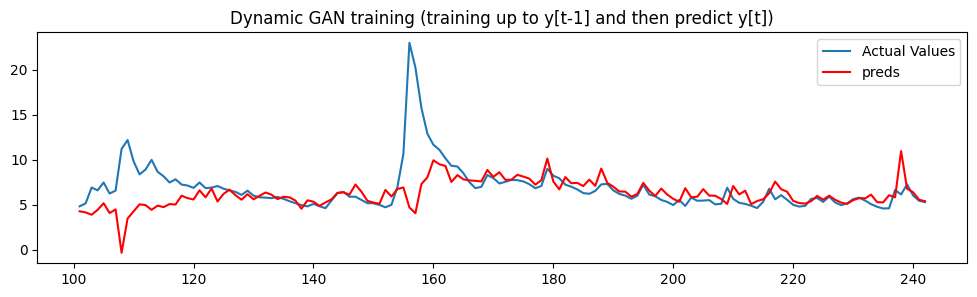

In [9]:
preds = []
ground_truth = []

X, y = x_austria, y_austria

for t in range(100, len(X) -1):
    X_train = X.iloc[:t]
    y_train = y[:t]

    gam = LinearGAM(s(9, lam=100) + te(9, 7) + s(1, lam=10) + s(7, lam=10) + te(1, 9))
    gam.fit(X_train, y_train)
    

    y_pred = gam.predict(X.iloc[[t]])
    edf = gam.statistics_['edof']
    print(edf)

    preds.append(y_pred[0])
    ground_truth.append(y[t])

plt.figure(figsize=(12, 3))
plt.plot(range(101, len(X)), ground_truth, label='Actual Values')
plt.plot(range(101, len(X)), preds, color='red', label='preds')
plt.title('Dynamic GAN training (training up to y[t-1] and then predict y[t])')
plt.legend()

plt.show()

### Experiments : Residuals and smoothing terms on the entire dataset

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.8883
Link Function:                     IdentityLink Log Likelihood:                                  -432.6191
Number of Samples:                          243 AIC:                                               873.015
                                                AICc:                                             873.1746
                                                GCV:                                                1.8371
                                                Scale:                                              1.7978
                                                Pseudo R-Squared:                                   0.7409
Feature Function                  Lam

/tmp/ipykernel_2593585/1627589697.py:7: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


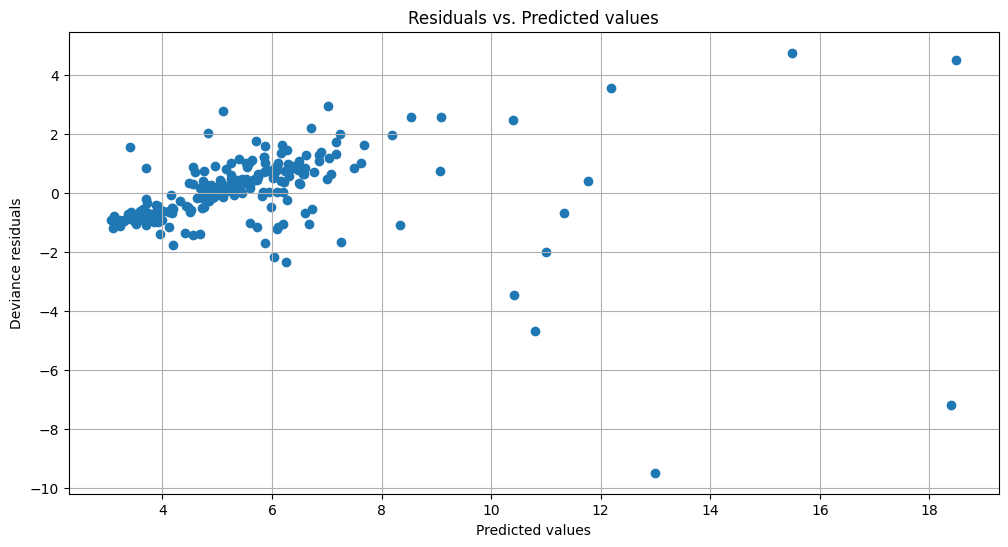

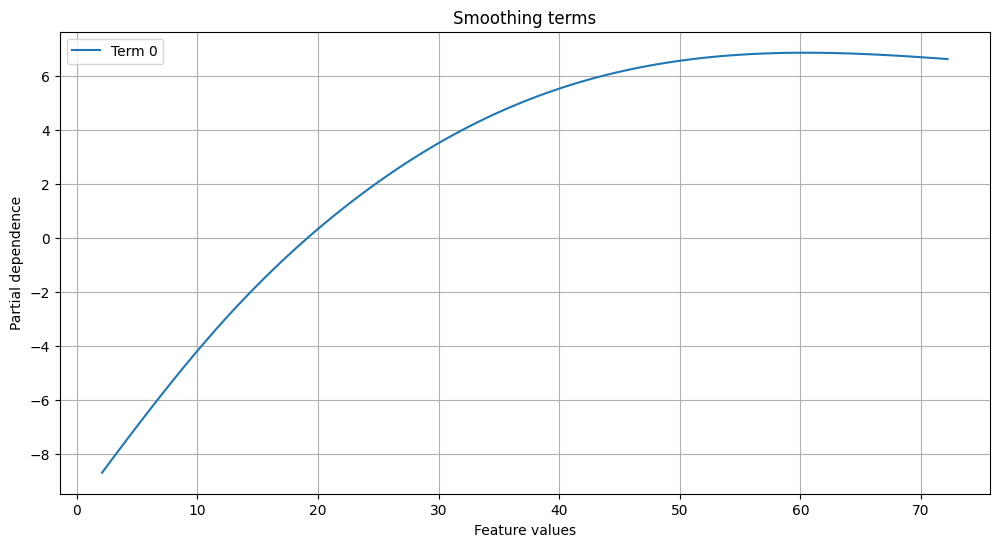

In [13]:
X, y = x_austria, y_austria

gam = LinearGAM(s(9, lam=10, n_splines=10))  # Ensure n_splines > spline_order

gam.fit(X, y)

gam.summary()

# residuals
plt.figure(figsize=(12, 6))
plt.scatter(gam.predict(X), gam.deviance_residuals(X, y))
plt.xlabel('Predicted values')
plt.ylabel('Deviance residuals')
plt.title('Residuals vs. Predicted values')
plt.grid(True)
plt.show()

#smoothing terms
plt.figure(figsize=(12, 6))
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue
    XX = gam.generate_X_grid(term=i)
    plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX), label=f'Term {i}')
plt.xlabel('Feature values')
plt.ylabel('Partial dependence')
plt.title('Smoothing terms')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
MAE(preds, ground_truth)

1.3785746964985308

Ici, idée : apprendre un nouveau spline à chaque étape : marche moyen car une seule valeur pour apprendre, chaque pas temporel est maintenant vu comme une feature. Toujours ce problème de décalage

## Dynamic GAMs + Kalman Filters

Lambda: 1, MAE: 1.2796901343321785
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      5.9287
Link Function:                     IdentityLink Log Likelihood:                                  -356.2933
Number of Samples:                          241 AIC:                                               726.444
                                                AICc:                                             726.9154
                                                GCV:                                                 1.194
                                                Scale:                                              1.1412
                                                Pseudo R-Squared:                                    0.839
Fe

/tmp/ipykernel_2593585/1714317201.py:31: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


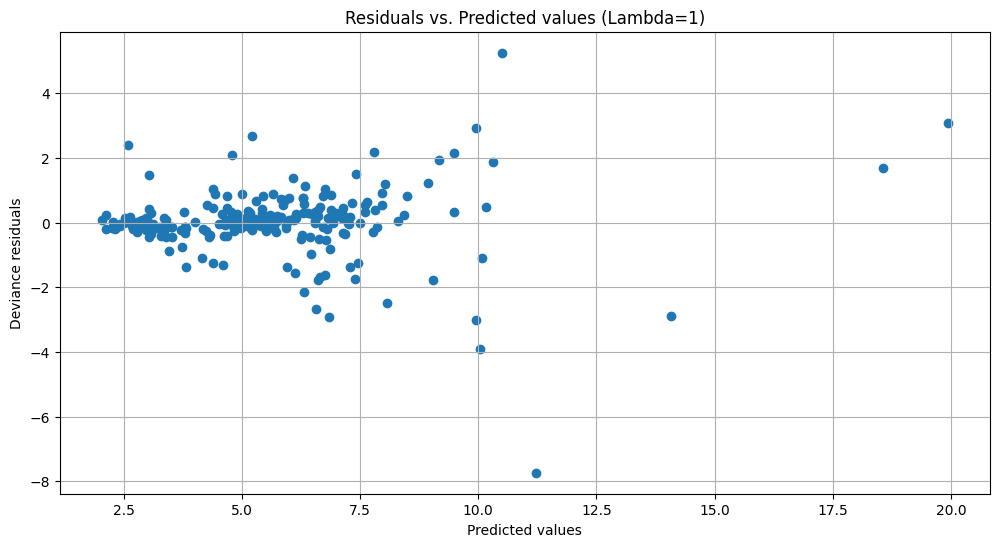

Lambda: 10, MAE: 1.1721168613124884
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       4.194
Link Function:                     IdentityLink Log Likelihood:                                   -393.276
Number of Samples:                          241 AIC:                                                796.94
                                                AICc:                                              797.214
                                                GCV:                                                1.5025
                                                Scale:                                              1.4555
                                                Pseudo R-Squared:                                   0.7931
F

/tmp/ipykernel_2593585/1714317201.py:31: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


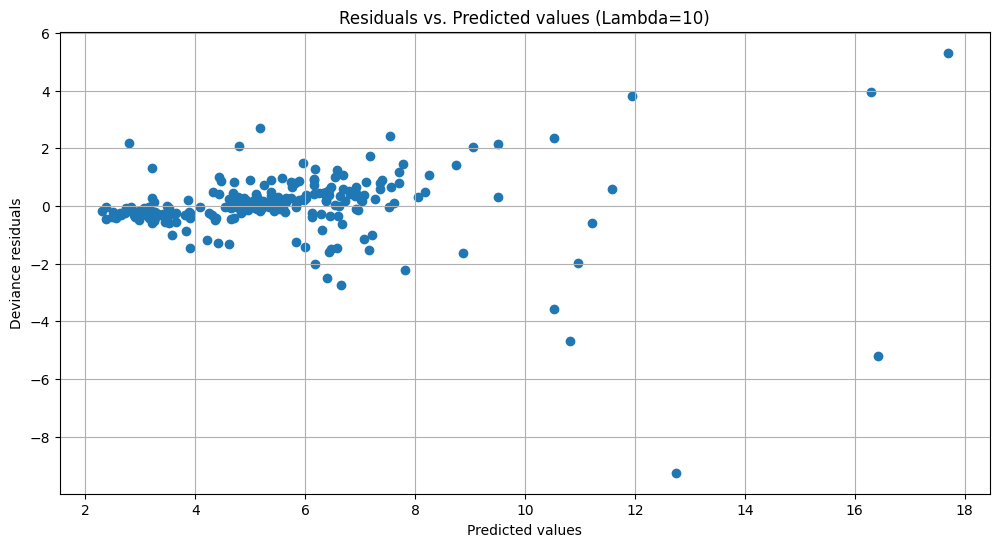

Lambda: 100, MAE: 1.2689852359472715
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      3.0815
Link Function:                     IdentityLink Log Likelihood:                                  -422.4463
Number of Samples:                          241 AIC:                                              853.0556
                                                AICc:                                             853.2314
                                                GCV:                                                 1.772
                                                Scale:                                              1.7312
                                                Pseudo R-Squared:                                   0.7528


/tmp/ipykernel_2593585/1714317201.py:31: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


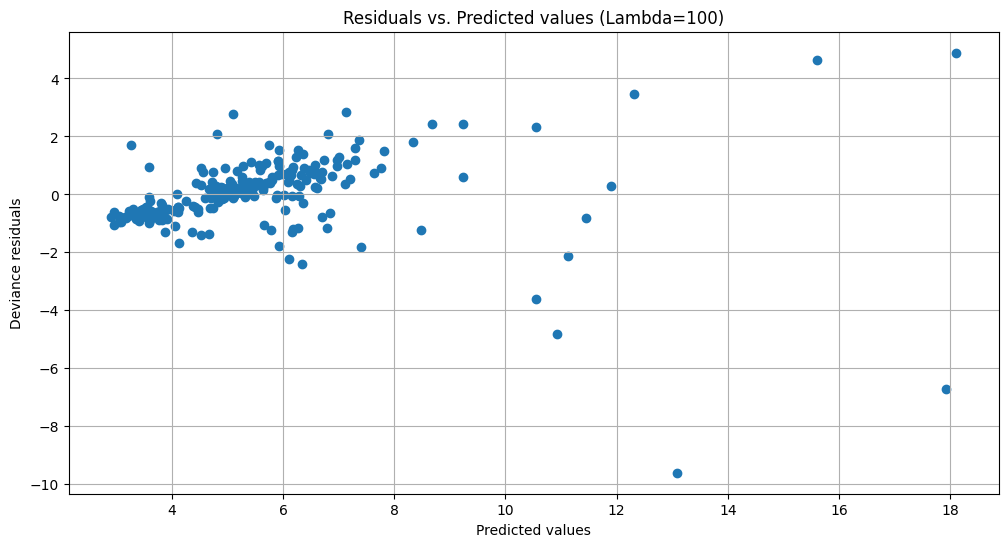

Lambda: 1000, MAE: 1.3756522343383415
LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      2.3363
Link Function:                     IdentityLink Log Likelihood:                                   -488.477
Number of Samples:                          241 AIC:                                              983.6265
                                                AICc:                                             983.7487
                                                GCV:                                                2.5241
                                                Scale:                                              2.4801
                                                Pseudo R-Squared:                                   0.6447

/tmp/ipykernel_2593585/1714317201.py:31: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


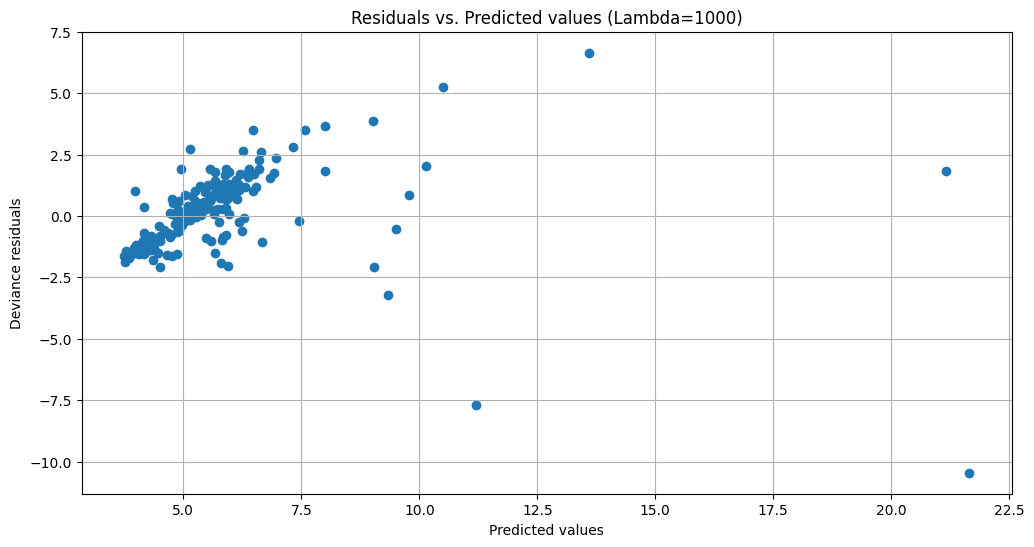

In [15]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.metrics import mean_absolute_error as MAE
import numpy as np

preds_dict = {}
ground_truth = []

X, y = x_austria, y_austria

lam_values = [1, 10, 100, 1000]
gams = []
for lam in lam_values:
    preds = []
    for t in range(100, len(X) - 1):
        X_train = X.iloc[:t]
        y_train = y[:t]
        
        gam = LinearGAM(s(9, lam=lam))
        gam.fit(X_train, y_train)
        y_pred = gam.predict(X.iloc[[t]])
        preds.append(y_pred[0])
    
    preds_dict[lam] = preds

    if not ground_truth:
        ground_truth = y[100:len(X)-1].tolist()
    print(f'Lambda: {lam}, MAE: {MAE(ground_truth, preds)}')

    gam.summary()
    gams.append(gam)

    # Plot the residuals
    plt.figure(figsize=(12, 6))
    plt.scatter(gam.predict(X), gam.deviance_residuals(X, y))
    plt.xlabel('Predicted values')
    plt.ylabel('Deviance residuals')
    plt.title(f'Residuals vs. Predicted values (Lambda={lam})')
    plt.grid(True)
    plt.show()


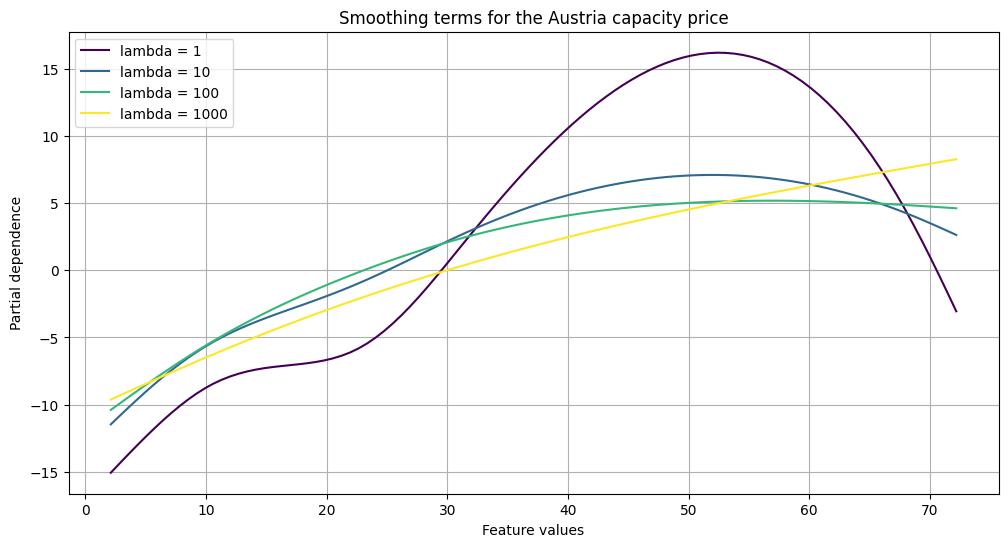

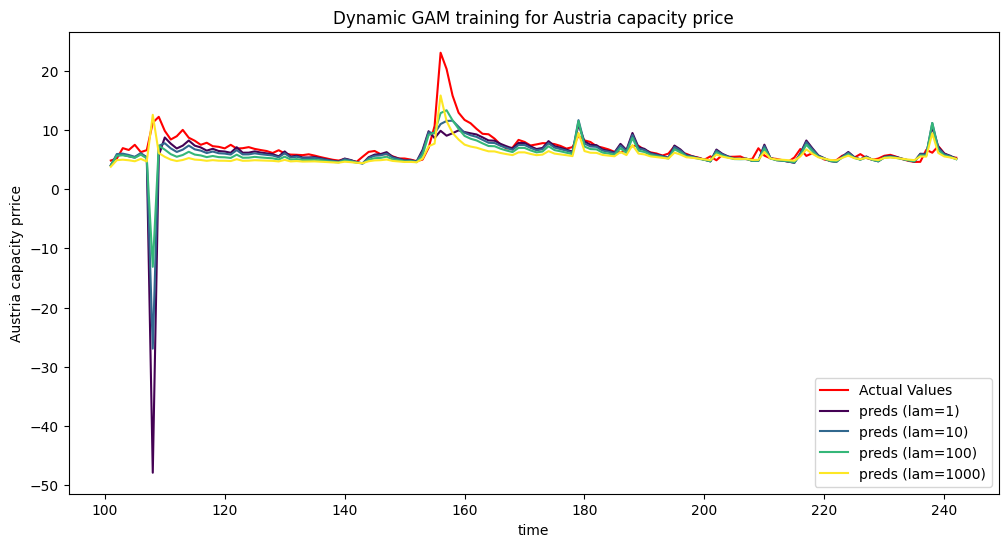

In [16]:

cmap = plt.get_cmap('viridis')
plt.figure(figsize=(12, 6))
colors = cmap(np.linspace(0, 1, len(lam_values)))
for j, gam in enumerate(gams):
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        XX = gam.generate_X_grid(term=i)
        plt.plot(XX[:, term.feature], gam.partial_dependence(term=i, X=XX), label=f'lambda = {lam_values[j]}', color=colors[j])
plt.xlabel('Feature values')
plt.ylabel('Partial dependence')
plt.title(f'Smoothing terms for the Austria capacity price')
plt.legend()
plt.grid(True)
plt.savefig("gam_partial_dependence_austria.png", dpi=300)
plt.show()


plt.figure(figsize=(12, 6))
plt.plot(range(101, len(X)), ground_truth, label='Actual Values', color='red')
for i, (lam, preds) in enumerate(preds_dict.items()):
    plt.plot(range(101, len(X)), preds, label=f'preds (lam={lam})', color=colors[i])

plt.title('Dynamic GAM training for Austria capacity price')
plt.xlabel('time')
plt.ylabel("Austria capacity prrice")
plt.legend()
plt.savefig("gam_austria.png", dpi=300)
plt.show()